<a href="https://colab.research.google.com/github/bharadwaj-vedula/Direct-Marketing-Optimisation/blob/main/Rebel_Foods_Modeling_CL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.   First model to classify if people will respond to mutual fund or not.
2.   Second model to classify if which consumer will respond to credit card
3.   Third model to classify which consumer will respond to Consumer Loan


---


4. Fourth model to if responds to mutual fund what will be expected revenue. (Train on all the folks who have mutual funds as it is a regression task)

5. Similarly for Credit card and Consumer Loans

# Imports

In [1]:
!pip install Optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 15.3 MB/s eta 0:00:00


In [2]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

In [31]:
import os
import pandas as pd
import numpy as np
from collections import Counter

import optuna

import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, StratifiedKFold,RepeatedStratifiedKFold,cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report,f1_score,average_precision_score,roc_auc_score

# Paths

In [4]:
class config:
  path = '/content/drive/MyDrive/Rebel Foods Assignment/DataScientist_CaseStudy_Dataset  (1) (1).xlsx'
  save_path = '/content/drive/MyDrive/Rebel Foods Assignment/Models'

In [6]:
df_dem = pd.read_excel(config.path,sheet_name = 'Soc_Dem')
df_actBalance = pd.read_excel(config.path,sheet_name = 'Products_ActBalance')
df_inflowOutflow = pd.read_excel(config.path, sheet_name = 'Inflow_Outflow')
df_salesRevenue = pd.read_excel(config.path,sheet_name = 'Sales_Revenues')

# Credit Card Propensity Model

### Data Perp

1. NaNs can be filled with zero as most of them are realted to count and balances.



In [7]:
cl_clients = df_salesRevenue.loc[df_salesRevenue['Sale_CL'] == 1]['Client'].tolist()

In [8]:
df = df_dem.merge(df_actBalance, how= 'inner',on='Client').merge(df_inflowOutflow,how= 'inner',on='Client').merge(df_salesRevenue,how= 'inner',on='Client')


In [9]:
sexMapping = {'F':np.int16(0),'M':np.int16(1)}
df['Sex'] = df['Sex'].map(sexMapping)
df.fillna(0,inplace= True)

In [10]:
df.drop(columns = ['Sale_MF', 'Sale_CC','Revenue_MF', 'Revenue_CC', 'Revenue_CL'], inplace= True)

In [11]:
df.columns

Index(['Client', 'Sex', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder', 'Sale_CL'],
      dtype='object')

In [12]:
print(df['Sale_CL'].value_counts(dropna= False))
print(df_salesRevenue['Sale_CL'].value_counts(dropna= False))

Sale_CL
0    662
1    289
Name: count, dtype: int64
Sale_CL
0    679
1    290
Name: count, dtype: int64


In [13]:
df

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_CL
0,1217,1.0,38,165,1,0.0,0.0,0.0,0.0,0.0,...,714.285714,0.000000,0.000000,714.285714,1,1,0,0,1,0
1,850,0.0,49,44,1,0.0,0.0,0.0,0.0,0.0,...,1226.345357,0.000000,0.000000,121.928571,6,6,0,0,1,0
2,1473,1.0,54,34,1,1.0,0.0,0.0,1.0,1.0,...,3794.580714,357.142857,444.597500,2076.785714,48,38,1,26,11,0
3,1038,1.0,29,106,1,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0
4,225,1.0,14,187,1,0.0,0.0,1.0,0.0,0.0,...,130.521429,0.000000,111.235714,19.285714,5,5,0,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,621,0.0,37,152,1,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,1,0,0,0,0,0
947,1276,1.0,28,145,1,0.0,0.0,0.0,0.0,2.0,...,155.107143,35.714286,0.000000,0.000000,6,4,1,0,0,0
948,384,1.0,23,160,1,0.0,0.0,0.0,0.0,0.0,...,88.443929,50.000000,37.372500,1.071429,8,8,2,5,1,1
949,977,1.0,46,59,1,0.0,0.0,0.0,0.0,0.0,...,76.103571,75.000000,1.067857,0.035714,4,4,2,1,1,0


## Train Test Split

In [14]:
df_train , df_test = train_test_split( df, test_size= 0.2 , stratify = df['Sale_CL'])

In [16]:
df_train['Sale_CL'].value_counts()

,count
Sale_CL,
0,529
1,231


In [18]:
df_test['Sale_CL'].value_counts()

,count
Sale_CL,
0,133
1,58


In [19]:
X = df_train.iloc[:,1:-1]
y = df_train.iloc[:,-1]

In [20]:
X

,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
585,0.0,53,53,1,1.0,0.0,1.0,0.0,0.0,213.068571,...,699.578214,699.578214,178.571429,65.649643,455.250000,14,14,1,1,11
380,0.0,25,67,1,0.0,0.0,0.0,0.0,0.0,5204.289643,...,1008.613571,1008.613571,639.028571,210.603214,155.160714,26,26,3,15,6
707,1.0,7,0,1,0.0,0.0,1.0,0.0,0.0,6236.142143,...,340.967143,131.221071,100.000000,0.000000,0.000000,7,5,3,0,0
114,1.0,67,50,1,0.0,0.0,0.0,0.0,0.0,443.860714,...,548.142857,548.142857,535.714286,0.000000,10.464286,3,3,1,0,1
367,1.0,28,110,1,0.0,0.0,0.0,0.0,1.0,7074.069286,...,796.182143,789.967857,146.428571,267.967857,280.500000,37,35,5,17,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,1.0,38,162,1,0.0,0.0,1.0,0.0,0.0,3723.582143,...,201.404286,201.404286,82.142857,18.297143,100.750000,12,12,6,4,1
328,1.0,55,181,3,0.0,0.0,0.0,0.0,0.0,778.102857,...,982.250714,982.250714,253.571429,636.536429,85.000000,37,37,6,27,3
376,0.0,18,150,1,0.0,0.0,0.0,1.0,1.0,18364.818571,...,1582.969643,1569.362500,364.285714,389.248214,615.792857,50,44,5,23,11
55,1.0,41,11,1,0.0,0.0,1.0,0.0,0.0,33573.151786,...,247.500000,247.500000,0.000000,0.000000,247.500000,5,5,0,0,5


In [21]:
y.value_counts()

,count
Sale_CL,
0,529
1,231


In [22]:
X_test = df_test.iloc[:,1:-1]
y_test = df_test.iloc[:,-1]

X_test

,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
711,1.0,28,68,1,1.0,0.0,0.0,0.0,0.0,1845.120714,...,752.285714,752.285714,107.142857,0.000000,642.857143,8,8,3,0,3
117,0.0,37,59,1,0.0,0.0,0.0,0.0,0.0,0.000000,...,359.107143,359.107143,357.142857,0.000000,0.000000,3,3,2,0,0
113,1.0,61,103,1,0.0,0.0,0.0,0.0,0.0,716.398571,...,322.500000,322.500000,178.571429,0.000000,141.535714,5,5,2,0,2
893,0.0,32,26,1,1.0,0.0,0.0,1.0,0.0,68.423571,...,1350.535357,1349.106786,0.000000,337.285714,1006.963929,23,21,0,4,15
635,0.0,85,205,1,1.0,0.0,1.0,1.0,0.0,5308.645000,...,1814.268929,1474.001071,535.714286,336.743214,609.453571,37,19,3,15,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,0.0,70,146,1,0.0,0.0,0.0,0.0,0.0,7.142857,...,1116.185714,1116.185714,357.142857,157.314286,360.428571,29,29,5,8,9
309,1.0,45,42,1,0.0,3.0,0.0,0.0,0.0,132.098571,...,2378.608929,2378.608929,0.000000,0.000000,2366.037500,23,23,0,0,21
618,1.0,70,16,1,0.0,0.0,0.0,0.0,0.0,6833.382857,...,175.214286,175.214286,0.000000,0.000000,172.821429,3,3,0,0,2
271,1.0,6,149,1,0.0,0.0,1.0,1.0,0.0,237.148571,...,433.047857,262.595357,0.000000,0.000000,139.392857,17,8,0,0,4


# XGBoost

In [ ]:
scores = {'f1_scores' : [], 'recall':[],'precision' : [],'accuracy':[],'auc_pr':[]}
for k,(train_idx, valid_idx) in enumerate(skf.split(X,y)):
  print(f'------------FOLD{k+1}------------')

  x_train = X.iloc[train_idx,1:].values
  y_train = y.iloc[train_idx].values

  x_valid = X.iloc[valid_idx,1:].values
  y_valid = y.iloc[valid_idx].values

  counter = Counter(y_train)
  weight = counter[0]/counter[1]

  # print(weight)

  clf = XGBClassifier()
  clf.fit(x_train,y_train)
  y_pred = clf.predict(x_valid)


  print(f'Accuracy score {accuracy_score(y_valid,y_pred)}')
  print(f'Recall score {recall_score(y_valid,y_pred)}')
  print(f'Precision score { precision_score(y_valid,y_pred)}')
  print(f'F1 score {f1_score(y_valid,y_pred)}')
  print(f'AUC PR {average_precision_score(y_valid,y_pred)}')
  print(f'Classification Report \n {classification_report(y_valid,y_pred)}')

  scores['f1_scores'].append(f1_score(y_valid,y_pred))
  scores['recall'].append(recall_score(y_valid,y_pred))
  scores['precision'].append(precision_score(y_valid,y_pred))
  scores['accuracy'].append(accuracy_score(y_valid,y_pred))
  scores['auc_pr'].append(average_precision_score(y_valid,y_pred))




NameError: name 'skf' is not defined

In [ ]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print(f'Mean F1 Scores {np.mean(scores["f1_scores"])}')
print(f'Mean Precision {np.mean(scores["precision"])}')
print(f'Mean Recall {np.mean(scores["recall"])}')
print(f'Mean AUC PR {np.mean(scores["auc_pr"])}')

Mean F1 Scores 0.20069449155335078
Mean Precision 0.3766666666666667
Mean Recall 0.14258064516129032
Mean AUC PR 0.23118958687040184


# Hyper parameter tuning

In [23]:
def objective(trial):
    """
    Objective function for Optuna to optimize.
    It trains an XGBoost Classifier with suggested hyperparameters and returns the
    cross-validated ROC AUC score.
    """
    param = {
        # 'objective': 'binary:logistic',
        'eval_metric': 'aucpr',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'tree_method': 'hist',
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-2, 10.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 0.5, log=True),
        'lambda': trial.suggest_float('lambda', 1e-8, 100.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 100.0, log=True),
        'use_label_encoder': False,
        'random_state': 2025,
        'n_jobs': -1,
        'early_stopping_rounds' : 50,

        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.6, 1.0)
    }

    if param['booster'] == 'dart':
        param['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
        param['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
        param['rate_drop'] = trial.suggest_float('rate_drop', 0.0, 0.5)
        param['skip_drop'] = trial.suggest_float('skip_drop', 0.0, 0.5)

    param['scale_pos_weight'] = trial.suggest_float(
        'scale_pos_weight',
        2.29 * 0.5,
        2.29 * 1.5,
        log=True
    )

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2025)
    roc_auc_scores = []

    for train_index, val_index in skf.split(X, y):
        X_train_fold, X_val_fold = X.iloc[train_index,1:].values, X.iloc[val_index,1:].values
        y_train_fold, y_val_fold = y.iloc[train_index].values, y.iloc[val_index].values

        model = XGBClassifier(**param)

        model.fit(X_train_fold, y_train_fold,
                  eval_set=[(X_val_fold, y_val_fold)],
                  verbose=False)

        val_preds_proba = model.predict(X_val_fold)

        if len(np.unique(y_val_fold)) == 2:
            f1 = f1_score(y_val_fold, val_preds_proba)
            roc_auc_scores.append(f1)
        else:
            continue

    if len(roc_auc_scores) > 0:
        return np.mean(roc_auc_scores)
    else:
        return 0.0


In [ ]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=2025))
print("Starting Optuna hyperparameter tuning...")
study.optimize(objective, n_trials=50, show_progress_bar=True)
print("Optuna tuning complete.")


In [25]:
print("\nBest trial:")
trial = study.best_trial

print(f"  Value (Mean CV F1 Score): {trial.value:.4f}")
print("  Best Parameters:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")



Best trial:
  Value (Mean CV F1 Score): 0.5004
  Best Parameters:
    booster: dart
    n_estimators: 575
    learning_rate: 0.04898228990586787
    max_depth: 7
    subsample: 0.631380461252265
    colsample_bytree: 0.820474137132975
    min_child_weight: 0.04208674152615503
    gamma: 2.4444989966855336e-06
    lambda: 46.18243305915624
    alpha: 0.0002460176254222749
    colsample_bylevel: 0.9551757406889658
    colsample_bynode: 0.7556850651293333
    sample_type: uniform
    normalize_type: forest
    rate_drop: 0.2844638953903054
    skip_drop: 0.26400787160789463
    scale_pos_weight: 2.554747380364099


In [26]:
best_params = trial.params
final_model = XGBClassifier(**best_params, use_label_encoder=False,
                                 eval_metric='aucpr',
                                 random_state=2025,
                                  n_jobs=-1,
                                  early_stopping_rounds = 50

                            )

print("\nTraining final model with best parameters...")
final_model.fit(X, y,
                eval_set=[(X_test, y_test)],
                verbose=True)



Training final model with best parameters...
[0]	validation_0-aucpr:0.41374
[1]	validation_0-aucpr:0.44438
[2]	validation_0-aucpr:0.45008
[3]	validation_0-aucpr:0.45457
[4]	validation_0-aucpr:0.43701
[5]	validation_0-aucpr:0.46137
[6]	validation_0-aucpr:0.46674
[7]	validation_0-aucpr:0.47020
[8]	validation_0-aucpr:0.48035
[9]	validation_0-aucpr:0.48203
[10]	validation_0-aucpr:0.47366
[11]	validation_0-aucpr:0.47386
[12]	validation_0-aucpr:0.45645
[13]	validation_0-aucpr:0.45606
[14]	validation_0-aucpr:0.46240
[15]	validation_0-aucpr:0.45954
[16]	validation_0-aucpr:0.46003
[17]	validation_0-aucpr:0.46482
[18]	validation_0-aucpr:0.46047
[19]	validation_0-aucpr:0.45593
[20]	validation_0-aucpr:0.45282
[21]	validation_0-aucpr:0.45312
[22]	validation_0-aucpr:0.44952
[23]	validation_0-aucpr:0.46806
[24]	validation_0-aucpr:0.47491
[25]	validation_0-aucpr:0.47619
[26]	validation_0-aucpr:0.47351
[27]	validation_0-aucpr:0.47409
[28]	validation_0-aucpr:0.47270
[29]	validation_0-aucpr:0.47578
[30]

XGBClassifier(alpha=0.0002460176254222749, base_score=None, booster='dart',
              callbacks=None, colsample_bylevel=0.9551757406889658,
              colsample_bynode=0.7556850651293333,
              colsample_bytree=0.820474137132975, device=None,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric='aucpr', feature_types=None,
              gamma=2.4444989966855336e-06, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              lambda=46.18243305915624, learning_rate=0.04898228990586787,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=0.04208674152615503, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=575,
              n_jobs=-1, ...)

In [27]:

y_pred_proba = final_model.predict(X_test)
y_pred_class = (y_pred_proba > 0.5).astype(int) # Default threshold of 0.5

# ROC AUC
test_roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test ROC AUC: {test_roc_auc:.4f}")

# Precision, Recall, F1-Score
test_precision = precision_score(y_test, y_pred_class)
test_recall = recall_score(y_test, y_pred_class)
test_f1 = f1_score(y_test, y_pred_class)

print(f"Test Precision (at 0.5 threshold): {test_precision:.4f}")
print(f"Test Recall (at 0.5 threshold): {test_recall:.4f}")
print(f"Test F1-Score (at 0.5 threshold): {test_f1:.4f}")


Evaluating final model on test set:
Test ROC AUC: 0.6202
Test Precision (at 0.5 threshold): 0.4250
Test Recall (at 0.5 threshold): 0.5862
Test F1-Score (at 0.5 threshold): 0.4928


# Saving Model

In [28]:
final_model.save_model('/content/drive/MyDrive/Rebel Foods Assignment/Models/XGBClassifier_CL.json')

In [29]:
final_model.feature_importances_

array([0.01038804, 0.05946916, 0.05860233, 0.03435382, 0.02476457,
       0.02843685, 0.01158529, 0.01248534, 0.0191008 , 0.04231646,
       0.03048693, 0.03380281, 0.03703553, 0.03952281, 0.03167333,
       0.02579213, 0.03581638, 0.03034022, 0.03368253, 0.04772127,
       0.05033066, 0.0293397 , 0.04169364, 0.0275699 , 0.03921683,
       0.04306928, 0.0448504 , 0.04357295, 0.03297999], dtype=float32)

Feature importances extracted and sorted.

Top 10 features by importance:
Age                             0.059469
Tenure                          0.058602
VolumeDeb_CA                    0.050331
VolumeDeb                       0.047721
TransactionsDebCash_Card        0.044850
TransactionsDebCashless_Card    0.043573
TransactionsDeb_CA              0.043069
ActBal_CA                       0.042316
VolumeDebCashless_Card          0.041694
ActBal_CC                       0.039523
dtype: float32

Generating feature importance plot...


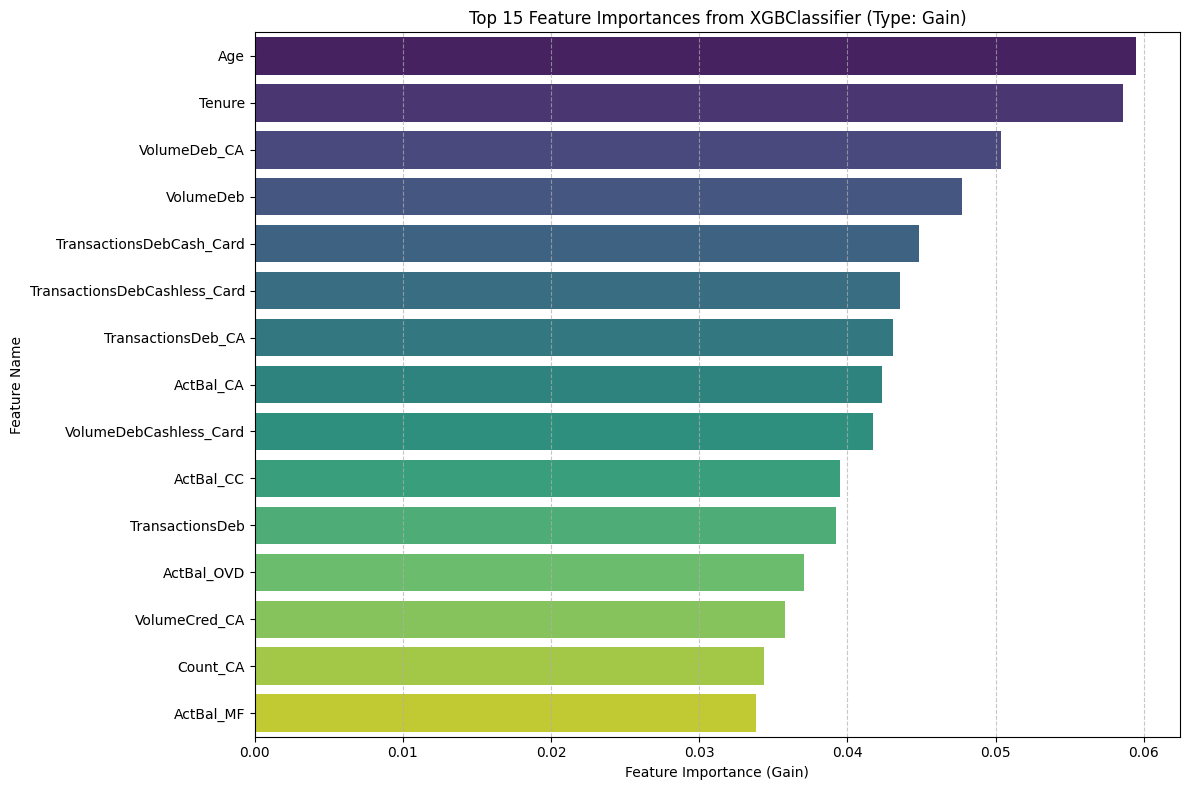


Feature importance plot displayed. You can save it using plt.savefig('feature_importance.png') if needed.


In [30]:
feature_importances = final_model.feature_importances_

importance_series = pd.Series(feature_importances, index=X.columns)

sorted_importance = importance_series.sort_values(ascending=False)

print("Feature importances extracted and sorted.")
print("\nTop 10 features by importance:")
print(sorted_importance.head(10))


num_features_to_plot = 15
top_features_to_plot = sorted_importance.head(num_features_to_plot)

plt.figure(figsize=(12, 8))

sns.barplot(x=top_features_to_plot.values, y=top_features_to_plot.index, palette='viridis')

plt.title(f'Top {num_features_to_plot} Feature Importances from XGBClassifier (Type: Gain)')
plt.xlabel('Feature Importance (Gain)')
plt.ylabel('Feature Name')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
